# Problem 4: Entanglement purification

solver: 房伯文

### (a) Circuit Construction

In [29]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.quantum_info import Statevector, partial_trace, state_fidelity

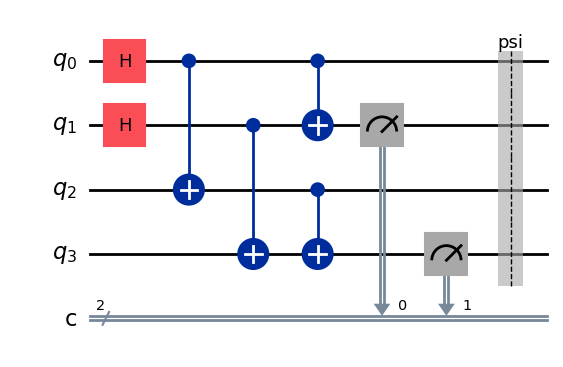

In [ ]:
qc_entangle = QuantumCircuit(4, 2)

qc_entangle.h(0)
qc_entangle.h(1)
qc_entangle.cx(0, 2)
qc_entangle.cx(1, 3)
qc_entangle.cx(0, 1)
qc_entangle.cx(2, 3)
qc_entangle.measure([1, 3], [0, 1])
qc_entangle.save_statevector(label="psi", conditional=True)
# qc_entangle.save_statevector(label="psi")

qc_entangle.draw("mpl")

When conditioned on measurement 00:
|0000>: (0.7071067811865477+0j)
|1010>: (0.7071067811865475+0j)
When conditioned on measurement 11:
|0101>: (0.7071067811865476+0j)
|1111>: (0.7071067811865476+0j)
Fidelity for measurement outcome 00: 1.0
Fidelity for measurement outcome 11: 1.0


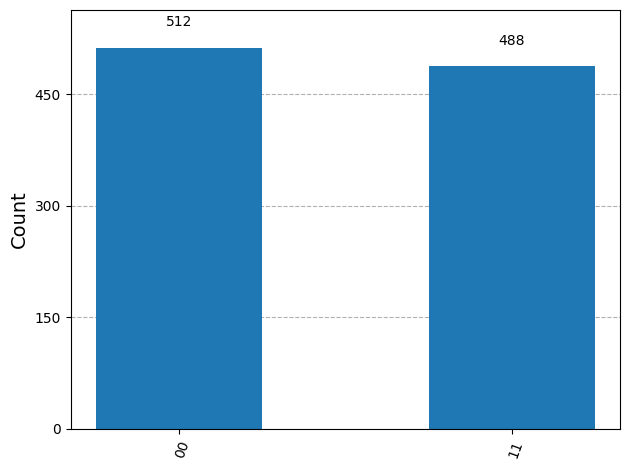

In [39]:
sim_entangle = AerSimulator(method="automatic")
qc_entangle_t = transpile(qc_entangle, sim_entangle)
result = sim_entangle.run(qc_entangle_t, shots=1000).result()

import numpy as np
# print(psi)
psi1 = result.data()["psi"]["0x0"]
psi1_rv = psi1.reverse_qargs()
psi2 = result.data()["psi"]["0x3"]
psi2_rv = psi2.reverse_qargs()

# print out conditioned statevector in component
threshold = 1e-10
print("When conditioned on measurement 00:")
nonzero_indices = np.where(abs(psi1_rv.data) > threshold)[0]
for idx in nonzero_indices:
    print(f"|{idx:04b}>: {psi1_rv.data[idx]}")

print("When conditioned on measurement 11:")
nonzero_indices = np.where(abs(psi2_rv.data) > threshold)[0]
# print(nonzero_indices.dtype)
for idx in nonzero_indices:
    print(f"|{idx:04b}>: {psi2_rv.data[idx]}")

# calculate partial_trace 
psi1_sv = Statevector(psi1)
psi2_sv = Statevector(psi2)

remaining_qubits = [0, 2]
psi1_reduced = partial_trace(psi1_sv, [1, 3])
psi2_reduced = partial_trace(psi2_sv, [1, 3])

rho1 = psi1_reduced.data
rho2 = psi2_reduced.data
# print(rho1)

# construct ideal EPR state
epr = Statevector([1/np.sqrt(2), 0, 0, 1/np.sqrt(2)])
# print(epr)
fidelity1 = state_fidelity(rho1, epr)
fidelity2 = state_fidelity(rho2, epr)

print("Fidelity for measurement outcome 00:", fidelity1)
print("Fidelity for measurement outcome 11:", fidelity2)

counts = result.get_counts()
plot_histogram(counts)

### (2) Purification

In [50]:
from qiskit_aer.noise import NoiseModel, depolarizing_error
p = 0.1
err = depolarizing_error(p, 2)
noise_model = NoiseModel(basis_gates=["rx", "ry", "rz", "cx"])
noise_model.add_quantum_error(err, "cx", [0, 2])
noise_model.add_quantum_error(err, "cx", [1, 3])

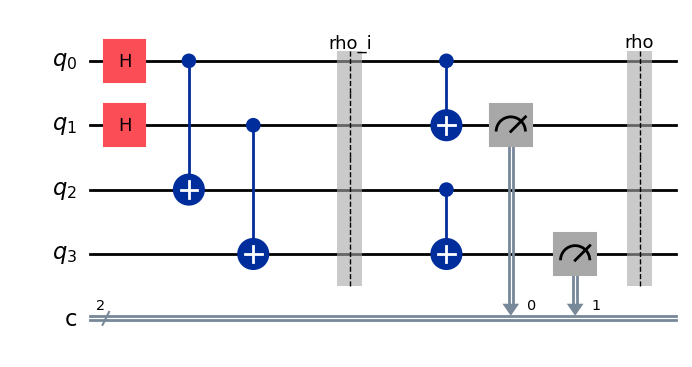

In [51]:
qc_pure = QuantumCircuit(4, 2)

qc_pure.h(0)
qc_pure.h(1)
qc_pure.cx(0, 2)
qc_pure.cx(1, 3)
qc_pure.save_density_matrix(label="rho_i")
qc_pure.cx(0, 1)
qc_pure.cx(2, 3)
qc_pure.measure([1, 3], [0, 1])
# qc_pure.save_statevector(label="psi", conditional=True)
qc_pure.save_density_matrix(label="rho", conditional=True)

qc_pure.draw("mpl")

Initial fidelity for qubit 0 and 2: 0.9219999999999998
Initial fidelity for qubit 1 and 3: 0.9309999999999999
Final fidelity conditioned on 00: 0.9525959367945823
Final fidelity conditioned on 11: 0.962555066079295
{'11': 454, '01': 45, '10': 58, '00': 443}


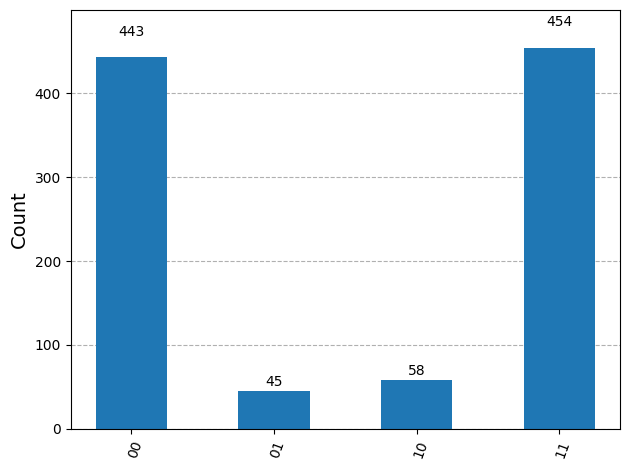

In [61]:
sim_pure = AerSimulator(method="automatic", noise_model=noise_model)

qc_pure_t = transpile(qc_pure, sim_pure)
result_pure = sim_pure.run(qc_pure_t, shots=1000).result()

rho_i = result_pure.data()["rho_i"]
rho_00 = result_pure.data()["rho"]["0x0"]
rho_11 = result_pure.data()["rho"]["0x3"]
# print(rho_00)

rho_i_1 = partial_trace(rho_i, [1, 3]).data
rho_i_2 = partial_trace(rho_i, [0, 2]).data
fidelity_i_1 = state_fidelity(rho_i_1, epr)
fidelity_i_2 = state_fidelity(rho_i_2, epr)
print("Initial fidelity for qubit 0 and 2:", fidelity_i_1)
print("Initial fidelity for qubit 1 and 3:", fidelity_i_2)

rho_00 = partial_trace(rho_00, [1, 3]).data
rho_11 = partial_trace(rho_11, [1, 3]).data
fidelity_00 = state_fidelity(rho_00, epr)
fidelity_11 = state_fidelity(rho_11, epr)
print("Final fidelity conditioned on 00:", fidelity_00)
print("Final fidelity conditioned on 11:", fidelity_11)

counts_pure = result_pure.get_counts()
print(counts_pure)
plot_histogram(counts_pure)